In [1]:
from os.path import join
from glob import glob
from utils.custom_utils import RetrieveData,new_dataset
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from photutils.segmentation import detect_sources, detect_threshold
import statmorph

from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss,roc_auc_score, precision_recall_fscore_support

In [2]:
URL='https://tinyurl.com/hdd4kwva'

RetrieveData(URL)
new_dataset()

Reconstructing RMS:   3%|█▉                                                         | 320/9470 [00:01<00:42, 214.90it/s]/home/clement/master_thesis/utils/custom_utils.py:96: RuntimeWarning: invalid value encountered in sqrt
  total_rms=np.sqrt(rms**2+source_ms)
Reconstructing RMS: 100%|██████████████████████████████████████████████████████████| 9470/9470 [00:42<00:00, 221.25it/s]


In [3]:
root_dir='./data/new_data/'

data_path=glob(join(root_dir,'lensed/*.fits'))+glob(join(root_dir,'non_lensed/*.fits'))
category=[1 for _ in range(len(glob(join(root_dir,'lensed/*.fits'))))]+[0 for _ in range(len(glob(join(root_dir,'non_lensed/*.fits'))))]

data_mapping=np.transpose([data_path,category])
rng = np.random.default_rng()
rng.shuffle(data_mapping)

In [4]:
def corner_value(image,size=5):
    dimensions=np.shape(image)
    
    data=image[:size,:size] #up left corner
    data=np.append(data,image[:size,dimensions[0]-size:]) #up right corner
    data=np.append(data,image[dimensions[0]-size:,:size]) #down left corner
    data=np.append(data,image[dimensions[0]-size:,dimensions[1]-size:]) #down right corner
    
    return data

def galaxy_map(segm):
    label = np.argmax(segm.areas)+1
    segm_map=1*(segm.data==label)
    return segm_map

def mask(segm):
    galaxy=(galaxy_map(segm))
    segm_map=segm.data!=0
    mask=segm_map-galaxy
    bool_mask=mask==1
    return bool_mask

In [5]:
def compute_parameters(file_path,n_sigma=3.5,npixels=5):
    directory=join(*file_path.split('/')[:-1])
    filename=file_path.split('/')[-1]
    rms_path=join(directory,'RMS',filename)
    psf_path=join(directory,'PSF',filename)
    
    image, header = fits.getdata(file_path, header=True)
    rms,rms_header=fits.getdata(rms_path,header=True)
    psf,psf_header=fits.getdata(psf_path,header=True)
    
    mean_background=np.mean(corner_value(image))
    std_background=np.std(corner_value(image))
    
    threshold=detect_threshold(image,n_sigma,background=mean_background,error=std_background)
    segm = detect_sources(image, threshold, npixels=npixels)
    
    Mask=mask(segm)
    segm_map=galaxy_map(segm)
    
    weight_map=1/rms
    
    try:
        source_morphs = statmorph.source_morphology(image, segm_map, weightmap=weight_map, mask=Mask,psf=psf)
        morph = source_morphs[0]
        return morph
    except:
        return None

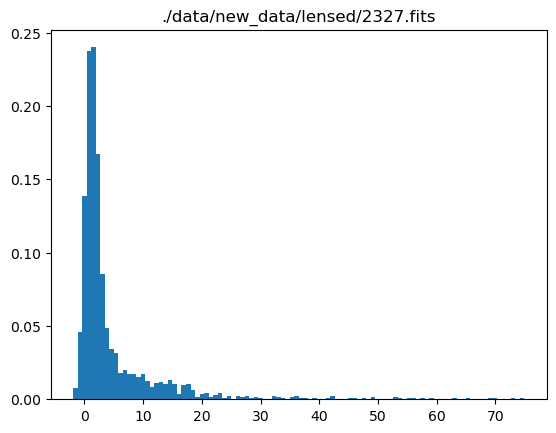

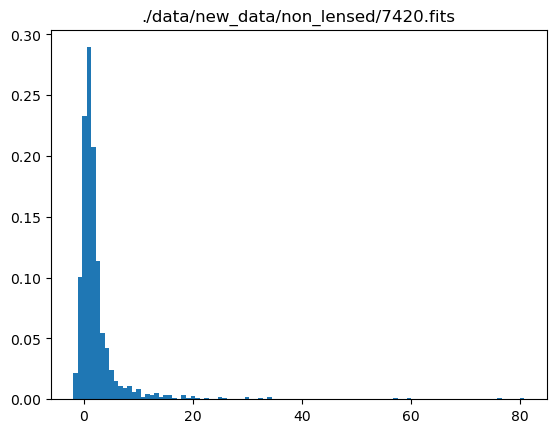

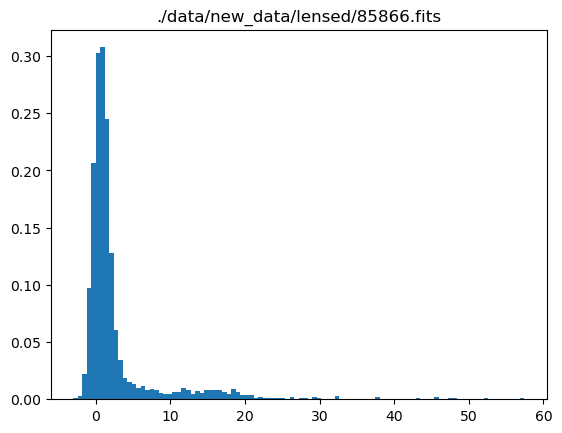

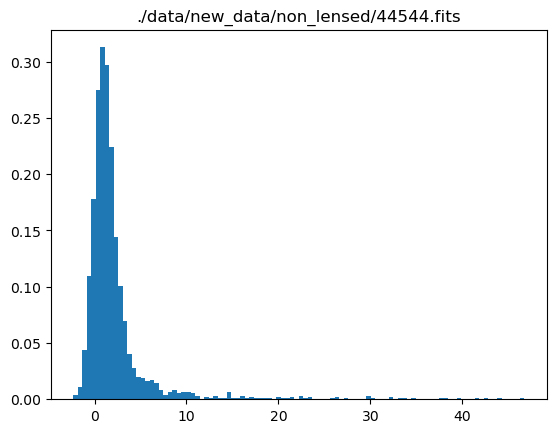

In [33]:
#test de la rms

for file in data_mapping[:4,0]:
    rms_path=join(*file.split('/')[:4],'RMS',file.split('/')[-1])
    image, header = fits.getdata(file, header=True)
    rms,rms_header=fits.getdata(rms_path,header=True)
    test=image/rms
    test=np.ravel(test)
    plt.hist(test, bins=100, density=True)
    plt.title(f'{file}')
    plt.show()

In [7]:
data={'file':[],'category':[],'flag_sersic':[],'flag_good':[],'flag_suspect':[],'flag_bad':[],'flag_catastrophic':[],'working':[],
     'sersic_amplitude':[],'sersic_rhalf':[],'sersic_n':[],'sersic_xc':[],'sersic_yc':[],'sersic_ellip':[],'sersic_theta':[],
     'asymmetry':[],'concentration':[],'deviation':[],'gini':[],'intensity':[],'m20':[],'rpetro_circ':[],'smoothness':[],'Z':[],'SNR':[]}
for file,category in tqdm(data_mapping[:2000]):
    params=compute_parameters(file)
    image, header = fits.getdata(file, header=True)
    if params:
        try:
            data['Z'].append(header['ZL'])
            data['SNR'].append(params.sn_per_pixel)
        except:
            data['Z'].append(header['REDSHIFT'])
            data['SNR'].append(params.sn_per_pixel)
        
        data['file'].append(file)
        data['category'].append(category)
        data['flag_sersic'].append(int(params.flag_sersic))
        data['flag_good'].append(1 if int(params.flag)==0 else 0)
        data['flag_suspect'].append(1 if int(params.flag)==1 else 0)
        data['flag_bad'].append(1 if int(params.flag)==2 else 0)
        data['flag_catastrophic'].append(1 if int(params.flag)==4 else 0)
        data['working'].append(1)
        
        data['sersic_amplitude'].append(params.sersic_amplitude)
        data['sersic_rhalf'].append(params.sersic_rhalf)
        data['sersic_n'].append(params.sersic_n)
        data['sersic_xc'].append(params.sersic_xc)
        data['sersic_yc'].append(params.sersic_yc)
        data['sersic_ellip'].append(params.sersic_ellip)
        data['sersic_theta'].append(params.sersic_theta)
        
        data['asymmetry'].append(params.asymmetry)
        data['concentration'].append(params.concentration)
        data['deviation'].append(params.deviation)
        data['gini'].append(params.gini)
        data['intensity'].append(params.intensity)
        data['m20'].append(params.m20)
        data['rpetro_circ'].append(params.rpetro_circ)
        data['smoothness'].append(params.smoothness)
        
    else:
        try:
            data['Z'].append(header['ZL'])
            data['SNR'].append(header['SN'])
        except:
            data['Z'].append(header['REDSHIFT'])
            data['SNR'].append(None)
        
        data['file'].append(file)
        data['category'].append(category)
        data['flag_sersic'].append(None)
        data['flag_good'].append(None)
        data['flag_suspect'].append(None)
        data['flag_bad'].append(None)
        data['flag_catastrophic'].append(None)
        data['working'].append(0)
        
        data['sersic_amplitude'].append(None)
        data['sersic_rhalf'].append(None)
        data['sersic_n'].append(None)
        data['sersic_xc'].append(None)
        data['sersic_yc'].append(None)
        data['sersic_ellip'].append(None)
        data['sersic_theta'].append(None)
        
        data['asymmetry'].append(None)
        data['concentration'].append(None)
        data['deviation'].append(None)
        data['gini'].append(None)
        data['intensity'].append(None)
        data['m20'].append(None)
        data['rpetro_circ'].append(None)
        data['smoothness'].append(None)
    

 10%|████████▍                                                                       | 210/2000 [01:23<10:23,  2.87it/s]/home/clement/anaconda3/envs/memoire/lib/python3.11/site-packages/astropy/modeling/functional_models.py:3109: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))
 38%|██████████████████████████████▋                                                 | 766/2000 [05:05<08:12,  2.50it/s]


AttributeError: 'NoneType' object has no attribute 'areas'

In [ ]:
df=pd.DataFrame(data)

In [ ]:
df.to_csv(join(root_dir,'data.csv'),index=False)

In [ ]:
df=pd.read_csv(join(root_dir,'data.csv'))

In [ ]:
#some statistics
#ratio of category
raw_ratio=len(df.loc[df['category']=='0'])/len(df)*100
print(f'dans le dataset il y a {raw_ratio} % qui sont non_lentillé et {100-raw_ratio} % de lentillé')

df_working=df.loc[df['working']==1]
working_ratio=len(df_working)/len(df)*100
print(f'le ratio de cas qui marche est de {working_ratio} % et de cas qui ne marche pas est {100-working_ratio} %.')

cat_working_ratio=len(df_working.loc[df_working['category']=='0'])/len(df_working)*100
print(f'au sein des cas qui marchent, il y a {cat_working_ratio} % de non_lentillés et {100-cat_working_ratio} % de lentillés')

print('\nOn ne prend plus que les cas qui marchent\n\n')
#flag ratio
perfect_working=len(df_working.loc[(df_working['flag_sersic']==0) & (df_working['flag_good']==1)])/len(df_working)*100
print(f'il y a {perfect_working} % de cas qui marchent parfaitement')
pur_sersic=len(df_working.loc[(df_working['flag_sersic']==1) & (df_working['flag_good']==1)])/len(df_working)*100
print(f'nombre de cas ou il y a seulement un flag sersic : {pur_sersic} %')
pur_flag=len(df_working.loc[(df_working['flag_sersic']==0) & (df_working['flag_good']==0)])/len(df_working)*100
print(f'nombre de cas ou il y a seulement un flag : {pur_flag} %')
both_flag=len(df_working.loc[(df_working['flag_sersic']==1) & (df_working['flag_good']==0)])/len(df_working)*100
print(f'il y a {both_flag} % de cas qui sont flagué aux deux\n')

pur_sersic=len(df_working.loc[(df_working['flag_sersic']==1) & (df_working['flag_good']==1)])/len(df_working)*100
print(f'nombre de cas ou il y a seulement un flag sersic : {pur_sersic} %')
flag1_sersic=len(df_working.loc[df_working['flag_sersic']==1].loc[df_working['flag_suspect']==1])/len(df_working)*100
flag2_sersic=len(df_working.loc[df_working['flag_sersic']==1].loc[df_working['flag_bad']==1])/len(df_working)*100
flag4_sersic=len(df_working.loc[df_working['flag_sersic']==1].loc[df_working['flag_catastrophic']==1])/len(df_working)*100
print(f'sersic + flag=1 :{flag1_sersic} %')
print(f'sersic + flag=2 :{flag2_sersic} %')
print(f'sersic + flag=4 :{flag4_sersic} %\n')

pur_flag=len(df_working.loc[(df_working['flag_sersic']==0) & (df_working['flag_good']==0)])/len(df_working)*100
print(f'nombre de cas ou il y a seulement un flag : {pur_flag} %')
flag1=len(df_working.loc[(df_working['flag_sersic']==0) & (df_working['flag_suspect']==1)])/len(df_working)*100
flag2=len(df_working.loc[(df_working['flag_sersic']==0) & (df_working['flag_bad']==1)])/len(df_working)*100
flag4=len(df_working.loc[(df_working['flag_sersic']==0) & (df_working['flag_catastrophic']==1)])/len(df_working)*100
print(f'nombre de cas flag=1 : {flag1} %')
print(f'nombre de cas flag=2 : {flag2} %')
print(f'nombre de cas flag=4 : {flag4} %')

In [10]:
df_working

,file,category,flag_sersic,flag_good,flag_suspect,flag_bad,flag_catastrophic,working,sersic_amplitude,sersic_rhalf,...,asymmetry,concentration,deviation,gini,intensity,m20,rpetro_circ,smoothness,Z,SNR
0,./data/new_data/non_lensed/33681.fits,0,0.0,1.0,0.0,0.0,0.0,1,36.692384,3.060699,...,0.003631,2.982785,0.018342,0.525094,0.000000,-1.864624,9.865059,0.048623,0.456810,56.649035
1,./data/new_data/non_lensed/81676.fits,0,0.0,1.0,0.0,0.0,0.0,1,43.323788,4.395135,...,0.079443,3.094711,0.042611,0.562369,0.060256,-1.829782,10.407149,0.031138,0.514988,47.661460
2,./data/new_data/non_lensed/90025.fits,0,0.0,1.0,0.0,0.0,0.0,1,2.458842,12.342801,...,0.007504,3.523516,0.032975,0.579138,0.011561,-2.136048,20.855389,-0.075053,0.420242,43.039710
4,./data/new_data/non_lensed/64731.fits,0,0.0,0.0,0.0,1.0,0.0,1,67.953073,5.164518,...,-0.007947,3.593725,0.020348,0.574766,0.000000,-2.051643,15.200222,-0.004982,0.283014,116.803854
5,./data/new_data/non_lensed/133089.fits,0,1.0,1.0,0.0,0.0,0.0,1,31.578382,16.776285,...,0.285071,3.177074,0.102598,0.537464,0.333729,-1.608992,21.880183,-0.050221,0.488940,40.341099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,./data/new_data/lensed/46471.fits,1,1.0,1.0,0.0,0.0,0.0,1,177.695997,7.134745,...,0.208997,2.855032,0.073605,0.463082,0.107657,-1.828718,13.559195,0.017836,0.556189,40.128973
1996,./data/new_data/lensed/117748.fits,1,1.0,1.0,0.0,0.0,0.0,1,4.418902,19.343801,...,0.126240,3.143797,0.057449,0.498390,0.065952,-1.914231,14.714485,-0.006636,0.518099,54.158718
1997,./data/new_data/non_lensed/79909.fits,0,0.0,1.0,0.0,0.0,0.0,1,35.010496,2.412754,...,-0.073082,2.887957,0.048728,0.528808,0.000000,-1.805475,10.898381,0.028518,0.468080,56.484773
1998,./data/new_data/lensed/114503.fits,1,1.0,1.0,0.0,0.0,0.0,1,399.036477,2.242388,...,0.161329,2.827799,0.043409,0.454950,0.108615,-1.866749,13.376988,0.009161,0.391655,92.697398


# SVM

In [11]:
#test en injectant tout
mat=df_working.loc[:,df.columns!='file']
y=np.array(mat.category)
X=np.array(mat.loc[:,mat.columns!='category'])

cut1,cut2=int(0.6*len(X)),int(0.8*len((X)))
X_train,X_valid,X_test=X[:cut1],X[cut1:cut2],X[cut2:]
y_train,y_valid,y_test=y[:cut1],y[cut1:cut2],y[cut2:]

clf = make_pipeline(StandardScaler(), SVC(gamma='auto',random_state=0))
clf=clf.fit(X_train, y_train)
    
score=clf.score(X_valid,y_valid)
print(f'score={score}\n')
    
pred=clf.predict(X_test)
    
conf_matrix=confusion_matrix(y_test,pred)
print(f'confusion matrix: \n{conf_matrix}')
print(f'len(X_test)={len(X_test)}\n')
acc=accuracy_score(y_test,pred)
precision,recall,fscore,support=precision_recall_fscore_support(y_test,pred,average='weighted')
print(f'Accuracy: {acc*100} %',f'Precision: {precision*100} %', f'Recall: {recall*100} %',f'F-score: {fscore*100} %',sep='\n')

score=0.9141274238227147

confusion matrix: 
[[184   8]
 [ 15 155]]
len(X_test)=362

Accuracy: 93.646408839779 %
Precision: 93.69725964330004 %
Recall: 93.646408839779 %
F-score: 93.63650293127056 %


conf matrix = [[TN,FP],
               [FN,TP]]

Accuracy= (TP+TN)/total #Number of correct prediction
Precision= TP/(TP+FP) = TP/positiv #Number of correct positive predictions out of all predicted positive
Recall= TP/(TP+FN) #Number of correct positive prediction out of really positive cases
F-score= 2*(pressicion*recall)/(precision+recall) #Harmonique mean of the precision and the recall

precision=1 ---> classifier don't make errors
recall=1 ---> classifier find all the relevant cases
F-score = 1 the best classifier

# Decision tree

In [12]:
clf = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(random_state=0))
clf=clf.fit(X_train, y_train)
    
score=clf.score(X_valid,y_valid)
print(f'score={score}\n')
    
pred=clf.predict(X_test)
    
conf_matrix=confusion_matrix(y_test,pred)
print(f'confusion matrix: \n{conf_matrix}')
print(f'len(X_test)={len(X_test)}\n')
acc=accuracy_score(y_test,pred)
precision,recall,fscore,support=precision_recall_fscore_support(y_test,pred,average='weighted')
print(f'Accuracy: {acc*100} %',f'Precision: {precision*100} %', f'Recall: {recall*100} %',f'F-score: {fscore*100} %',sep='\n')

score=0.8698060941828255

confusion matrix: 
[[181  11]
 [ 23 147]]
len(X_test)=362

Accuracy: 90.60773480662984 %
Precision: 90.75069009350715 %
Recall: 90.60773480662984 %
F-score: 90.5782321258672 %


# Random Forest

In [13]:
clf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500,warm_start=True, random_state=0))
clf=clf.fit(X_train, y_train)
    
score=clf.score(X_valid,y_valid)
print(f'score={score}\n')
    
pred=clf.predict(X_test)
    
conf_matrix=confusion_matrix(y_test,pred)
print(f'confusion matrix: \n{conf_matrix}')
print(f'len(X_test)={len(X_test)}\n')
acc=accuracy_score(y_test,pred)
precision,recall,fscore,support=precision_recall_fscore_support(y_test,pred,average='weighted')
print(f'Accuracy: {acc*100} %',f'Precision: {precision*100} %', f'Recall: {recall*100} %',f'F-score: {fscore*100} %',sep='\n')

score=0.9362880886426593

confusion matrix: 
[[182  10]
 [  5 165]]
len(X_test)=362

Accuracy: 95.85635359116023 %
Precision: 95.89834929451439 %
Recall: 95.85635359116023 %
F-score: 95.85904725445991 %


In [14]:
clf.decision_path(X_test)

AttributeError: 'Pipeline' object has no attribute 'decision_path'

# MLP

In [135]:
clf = make_pipeline(StandardScaler(), MLPClassifier(warm_start=True,random_state=1))
clf=clf.fit(X_train, y_train)
    
score=clf.score(X_valid,y_valid)
print(f'score={score}\n')
    
pred=clf.predict(X_test)
    
conf_matrix=confusion_matrix(y_test,pred)
print(f'confusion matrix: \n{conf_matrix}')
print(f'len(X_test)={len(X_test)}\n')
acc=accuracy_score(y_test,pred)
precision,recall,fscore,support=precision_recall_fscore_support(y_test,pred,average='weighted')
print(f'Accuracy: {acc*100} %',f'Precision: {precision*100} %', f'Recall: {recall*100} %',f'F-score: {fscore*100} %',sep='\n')

score=0.9375

confusion matrix: 
[[182  16]
 [ 10 160]]
len(X_test)=368

Accuracy: 92.93478260869566 %
Precision: 92.99808547430828 %
Recall: 92.93478260869566 %
F-score: 92.94169389293793 %


/home/clement/anaconda3/envs/memoire/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# KNN

In [147]:
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=55))
clf=clf.fit(X_train, y_train)
    
score=clf.score(X_valid,y_valid)
print(f'score={score}\n')
    
pred=clf.predict(X_test)
    
conf_matrix=confusion_matrix(y_test,pred)
print(f'confusion matrix: \n{conf_matrix}')
print(f'len(X_test)={len(X_test)}\n')
acc=accuracy_score(y_test,pred)
precision,recall,fscore,support=precision_recall_fscore_support(y_test,pred,average='weighted')
print(f'Accuracy: {acc*100} %',f'Precision: {precision*100} %', f'Recall: {recall*100} %',f'F-score: {fscore*100} %',sep='\n')

score=0.9375

confusion matrix: 
[[181  17]
 [ 21 149]]
len(X_test)=368

Accuracy: 89.67391304347827 %
Precision: 89.67559864944063 %
Recall: 89.67391304347827 %
F-score: 89.66407867494823 %
